In [1]:
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline



env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:
import rasterio
from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm
from skimage.external import tifffile as sktif

# import shapely.wkt
import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

W0908 17:04:38.100476 140030652692288 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/metrics.py:103: The name tf.keras.metrics.cosine_proximity is deprecated. Please use tf.keras.losses.cosine_similarity instead.

W0908 17:04:38.141827 140030652692288 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/_keras_losses.py:104: The name tf.keras.losses.cosine is deprecated. Please use tf.keras.losses.cosine_similarity instead.



In [3]:
data_dir = Path("/media/wwymak/Storage/spacenet_roads")
mumbai = data_dir/"AOI_8_Mumbai"
ms_mumbai = mumbai/"MS"
ps_rgb_mumbai = mumbai/"PS-RGB"

In [4]:
from utils import create_small_tiles, scale_percentile

In [5]:
mask_folder = mumbai / "masks"

mask_512_folder = mumbai /"masks_512"
mask_512_folder.mkdir(exist_ok=True)

rgb_512_folder = mumbai /"rgb_512"
rgb_512_folder.mkdir(exist_ok=True)

img_fnames = ps_rgb_mumbai.ls()
img_ids = [x.name.replace('.tif', '').split('_')[-1] for x in img_fnames]
mask_fnames =[ mask_folder / f"{img_id}.png" for img_id in img_ids]



In [6]:
valid_imgs = list(set([x.name.split('_')[2] for x in rgb_512_folder.ls() if x.name.endswith('.jpg')]))
np.random.seed(42)
mumbai_ids = np.array(valid_imgs)
np.random.shuffle(mumbai_ids)
np.random.seed(None)

In [7]:
len(valid_imgs), len(mumbai_ids)

(641, 641)

#### Training Tile creation

only create tiles for images with roads, and only save tiles with stretches of road on them

In [57]:
task_fn = partial(create_small_tiles,save_dir_rgb=rgb_512_fold,save_dir_mask=mask_512_folder)
%time _= Parallel(n_jobs=16)(delayed(task_fn)(img_filepath,mask_filepath,im_id) for (img_filepath,mask_filepath,im_id) in zip(img_fnames, mask_fnames, img_ids))

# %time _= [create_small_tiles( img_filepath,mask_filepath,im_id,rgb_512_fold,mask_512_folder,new_img_height=512) for  (img_filepath,mask_filepath,im_id) in zip(img_fnames, mask_fnames, img_ids)]

CPU times: user 1.45 s, sys: 276 ms, total: 1.73 s
Wall time: 1min 56s


#### modelling round1

In [8]:
train_ids = mumbai_ids[:int(0.8*len(mumbai_ids))]
valid_ids = mumbai_ids[int(0.8*len(mumbai_ids)):]

print(len(train_ids), len(valid_ids))

512 129


In [9]:
def get_mask_fn(fname):
    return mask_512_folder / fname.name.replace("rgb", "mask").replace("jpg", "png")


def is_valid_image(filepath):
    img_name = Path(filepath).name
    img_id = img_name.split('_')[2]
    return img_id in mumbai_ids

def is_in_validation_set(filepath):
    img_name = Path(filepath).name
    img_id = img_name.split('_')[2]
    return img_id in valid_ids

codes = np.array(["void", "road"])

src = (SegmentationItemList.from_folder(rgb_512_folder)
       .filter_by_func(is_valid_image)
       .split_by_valid_func(is_in_validation_set)
       .label_from_func(get_mask_fn, classes=codes)
      )

bs = 4
size=256

data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

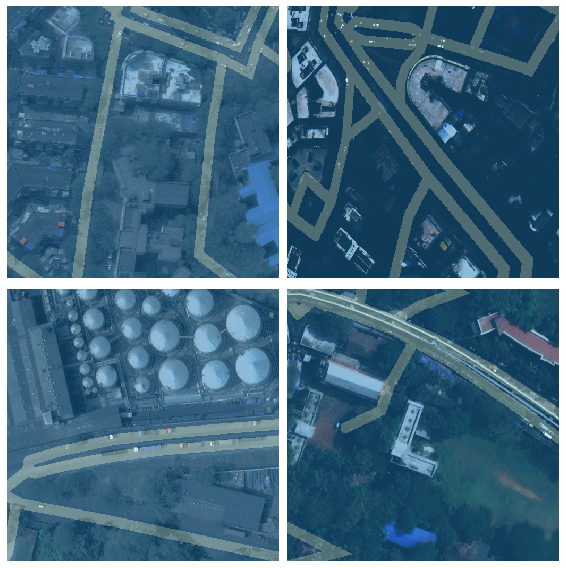

In [11]:
data.show_batch()

In [10]:
wd =1e-2
metrics = [partial(foreground_acc, void_code=0),dice]
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (15926 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512;

Valid: LabelList (3960 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentu

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


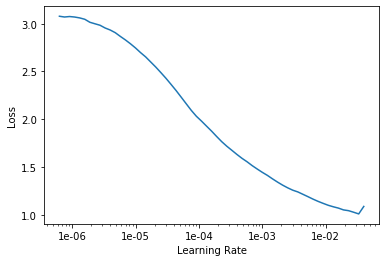

In [13]:
learn.recorder.plot(skip_end=1)

In [15]:
lr=1e-3
callbacks=[SaveModelCallback(learn, every='improvement', monitor='dice', name='mumbai-model-resnet34-1')]
learn.fit_one_cycle(20, slice(lr), callbacks=callbacks)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.201839,0.186226,0.414397,0.505023,05:22
1,0.204358,0.186474,0.432296,0.517699,05:24
2,0.197582,0.181996,0.433391,0.520887,05:24
3,0.202759,0.184112,0.411548,0.505691,05:23
4,0.192393,0.185684,0.398681,0.497846,05:36
5,nan,2.412372,0.000000,0.000000,05:19


Better model found at epoch 0 with dice value: 0.5050227046012878.
Better model found at epoch 1 with dice value: 0.5176989436149597.
Better model found at epoch 2 with dice value: 0.5208874344825745.


KeyboardInterrupt: 

In [16]:
learn.load('mumbai-model-resnet34-1')

Learner(data=ImageDataBunch;

Train: LabelList (15926 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512;

Valid: LabelList (3960 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentu

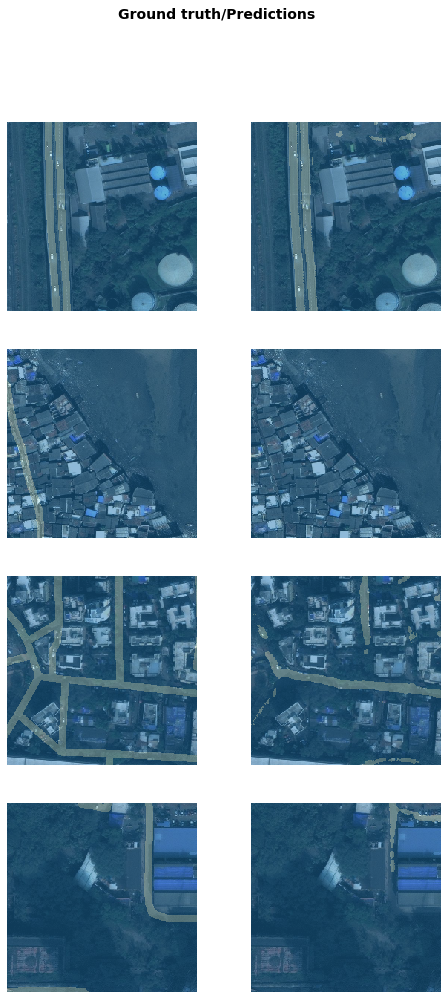

In [17]:
learn.show_results()

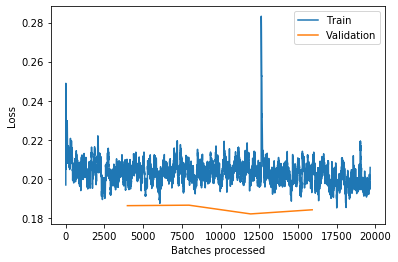

In [20]:
# learn.lr_find()
learn.recorder.plot_losses(skip_end=5000)

In [ ]:
callbacks=[SaveModelCallback(learn, every='improvement', monitor='dice', name='mumbai-model-resnet34-2'),
          TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1)
          ]